In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from dataset import *
from save_load import *
from NN_library.PINN.PINN import *
from NN_library.PINN.train_PINN import *
from matplotlib.tri import Triangulation
%load_ext autoreload
%autoreload 2

Using device: cuda


In [2]:
data = dataset_Sobol(14, [0, 2*np.pi], [0, 2*np.pi])
loaders = get_loaders_Sobol(data, 2**14)

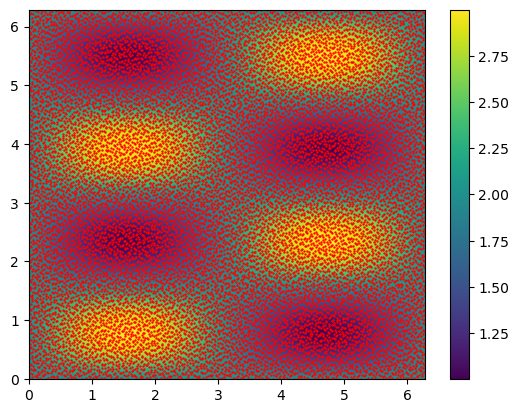

In [3]:
L = 2*np.pi
N = 512 # number of nodes in each direction including the border
H1 = torch.tensor([1, 0], device=dev).view(1, 2) # macrogradient
H2 = torch.tensor([0, 1], device=dev).view(1, 2) # macrogradient
x = np.linspace(0, L, N, endpoint=True)
y = np.linspace(0, L, N, endpoint=True)

XY = np.meshgrid(x, y)
grid_data = torch.tensor(np.vstack((XY[0].flatten(), XY[1].flatten())).T, dtype=torch.float, device=dev)
def a_function(x,y):
    a = 2+np.sin(x)*np.sin(2*y)
    return a
def A(x):
    a = (2+torch.sin(x[:,0])*torch.sin(2*x[:,1])).view(-1,1,1)
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = a * I
    return A
Z = a_function(XY[0].flatten(),XY[1].flatten())
plt.pcolormesh(XY[0], XY[1], Z.reshape(N, N))
plt.colorbar()
plt.scatter(data[:,0], data[:,1], s = 0.5, c='r')

In [4]:
net_H1 = PINN(n_periodic=40, n_hidden=80, n_layers=3, period_len=L)
total_params = sum(p.numel() for p in net_H1.parameters())
print(f"Number of parameters: {total_params}")
args = {'lr' : 0.0005, 'epochs' : 5000, 'dev' : dev, 'name' : f'NN_library/PINN/PINN_H1_{total_params}'}

Number of parameters: 26401


In [ ]:
net_H1 = load_network(net_H1, args['name']+'', args)
net_H1 = net_H1.to(dev)

In [5]:
losses_train, losses_val = train(net_H1, loaders, args, A, H1)

Epoch: 0 mean train loss:  5.40600478e-01, mean val. rec. loss:  3.18750733e-01
Epoch: 1 mean train loss:  3.18677152e-01, mean val. rec. loss:  2.50893247e-01
Epoch: 2 mean train loss:  2.50830468e-01, mean val. rec. loss:  2.14799625e-01
Epoch: 3 mean train loss:  2.14753984e-01, mean val. rec. loss:  1.86046514e-01
Epoch: 4 mean train loss:  1.86007713e-01, mean val. rec. loss:  1.63180466e-01
Epoch: 5 mean train loss:  1.63149848e-01, mean val. rec. loss:  1.45584007e-01
Epoch: 6 mean train loss:  1.45553518e-01, mean val. rec. loss:  1.30045860e-01
Epoch: 7 mean train loss:  1.30016058e-01, mean val. rec. loss:  1.14091708e-01
Epoch: 8 mean train loss:  1.14062150e-01, mean val. rec. loss:  9.82429060e-02
Epoch: 9 mean train loss:  9.82152916e-02, mean val. rec. loss:  8.45255449e-02
Epoch: 10 mean train loss:  8.45027071e-02, mean val. rec. loss:  7.38471323e-02
Epoch: 11 mean train loss:  7.38284543e-02, mean val. rec. loss:  6.52836857e-02
Epoch: 12 mean train loss:  6.52667301

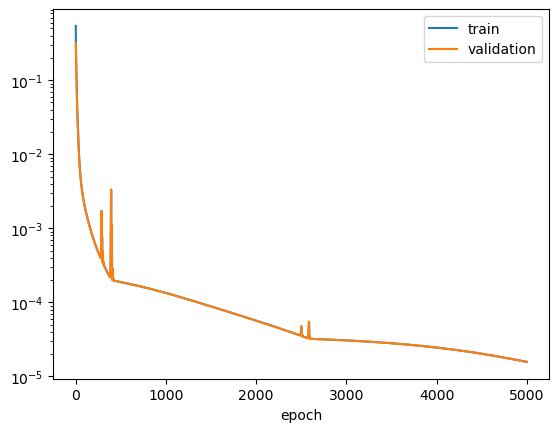

In [6]:
plt.plot(losses_train)
plt.plot(losses_val)
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.yscale('log')

In [7]:
net_H2 = PINN(n_periodic=40, n_hidden=80, n_layers=3, period_len=L)
total_params = sum(p.numel() for p in net_H2.parameters())
print(f"Number of parameters: {total_params}")
args = {'lr' : 0.0005, 'epochs' : 5000, 'dev' : dev, 'name' : f'NN_library/PINN/PINN_H2_{total_params}'}

Number of parameters: 26401


In [14]:
net_H2 = load_network(net_H2, args['name']+'_4999', args)
net_H2 = net_H2.to(dev)

In [8]:
losses_train, losses_val = train(net_H2, loaders, args, A, H2)

Epoch: 0 mean train loss:  1.24586563e+00, mean val. rec. loss:  1.00916340e+00
Epoch: 1 mean train loss:  1.00898879e+00, mean val. rec. loss:  8.97107645e-01
Epoch: 2 mean train loss:  8.96896061e-01, mean val. rec. loss:  8.26869026e-01
Epoch: 3 mean train loss:  8.26647269e-01, mean val. rec. loss:  7.72805376e-01
Epoch: 4 mean train loss:  7.72590985e-01, mean val. rec. loss:  7.22042560e-01
Epoch: 5 mean train loss:  7.21857890e-01, mean val. rec. loss:  6.69212532e-01
Epoch: 6 mean train loss:  6.69033979e-01, mean val. rec. loss:  6.13669524e-01
Epoch: 7 mean train loss:  6.13508985e-01, mean val. rec. loss:  5.56589315e-01
Epoch: 8 mean train loss:  5.56446717e-01, mean val. rec. loss:  4.99231182e-01
Epoch: 9 mean train loss:  4.99098414e-01, mean val. rec. loss:  4.42652536e-01
Epoch: 10 mean train loss:  4.42534477e-01, mean val. rec. loss:  3.88159209e-01
Epoch: 11 mean train loss:  3.88058417e-01, mean val. rec. loss:  3.37589731e-01
Epoch: 12 mean train loss:  3.37497700

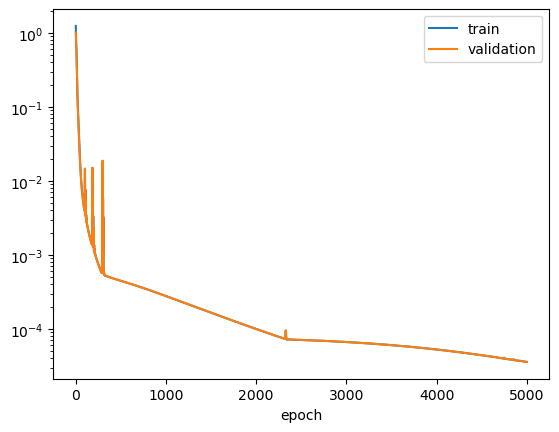

In [9]:
plt.plot(losses_train)
plt.plot(losses_val)
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.yscale('log')

In [10]:
U1 = net_H1(grid_data).detach().cpu()
U2 = net_H2(grid_data).detach().cpu()

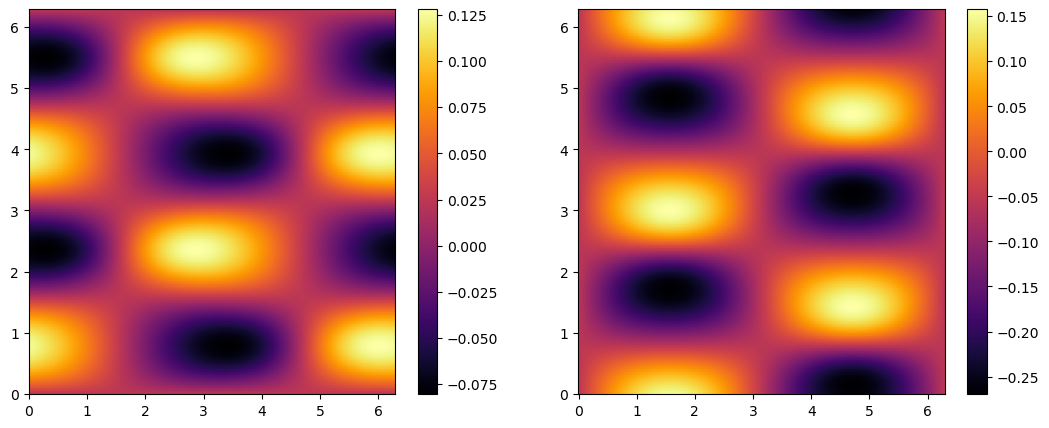

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(13,5))
pos1 = axs[0].pcolormesh(XY[0], XY[1], U1.reshape(N, N), cmap='inferno')
fig.colorbar(pos1, ax=axs[0])
pos2 = axs[1].pcolormesh(XY[0], XY[1], U2.reshape(N, N), cmap='inferno')
fig.colorbar(pos2, ax=axs[1])

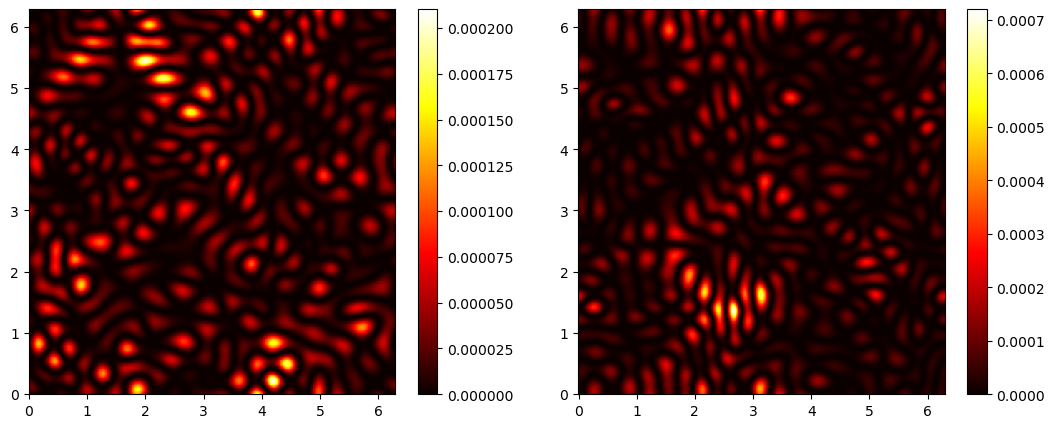

In [12]:
error_1 = PDE_loss(grid_data, net_H1, A, H1).detach().cpu()
error_2 = PDE_loss(grid_data, net_H2, A, H2).detach().cpu()
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(13,5))
pos1 = axs[0].pcolormesh(XY[0], XY[1], error_1.reshape(N, N), cmap='hot')
#axs[0].scatter(data[:,0], data[:,1], s=0.5, c='g')
fig.colorbar(pos1, ax=axs[0])
pos2 = axs[1].pcolormesh(XY[0], XY[1], error_2.reshape(N, N), cmap='hot')
#axs[1].scatter(data[:,0], data[:,1], s=0.5, c='g')
fig.colorbar(pos2, ax=axs[1])

In [13]:
inputs = data[:].to(dev).requires_grad_(True)
T1 = net_H1(inputs)
T2 = net_H2(inputs)
dq1 = torch.autograd.grad(
            outputs=T1, inputs=inputs,
            grad_outputs=torch.ones_like(T1),
            create_graph=True, retain_graph=True
    )[0].detach()
dq2 = torch.autograd.grad(
            outputs=T2, inputs=inputs,
            grad_outputs=torch.ones_like(T2),
            create_graph=True, retain_graph=True
    )[0].detach()
triang = Triangulation(data[:,0], data[:,1])
n_elem = len(triang.triangles)

In [ ]:
def compute_bound(dq1, dq2, tri, data):
    # Compute the A_h
    A_h = np.zeros((2,2))
    n_elem = len(tri.triangles)
    for i in range(n_elem):
        elem = tri.triangles[i]
        node_coords = data[elem]
        vector = node_coords[1:]-node_coords[:-1]
        vectors = torch.hstack((vector, torch.tensor([[0], [0]], device=dev)))
        area = (1/2) * abs(torch.cross(vectors[0], vectors[1])[-1])
        A_loc = A(node_coords)
        Q1 = A_loc @ (dq1[elem] + H1).view(3,2,1)
        Q2 = A_loc @ (dq2[elem] + H2).view(3,2,1)
        Q1_mean = Q1.mean(dim=0)
        Q2_mean = Q2.mean(dim=0)
        A_h_elem_1 = (area * Q1_mean).squeeze().detach().cpu().numpy()
        A_h_elem_2 = (area * Q2_mean).squeeze().detach().cpu().numpy()
        A_h[:,0] += A_h_elem_1
        A_h[:,1] += A_h_elem_2
    return A_h / L**2

In [15]:
A_bound = compute_bound(dq1, dq2, triang, inputs)
print(A_bound)

[[1.97440282e+00 5.05145877e-05]
 [4.93877873e-05 1.89551895e+00]]


In [17]:
np.save(f'bounds/A_u_NN_{total_params}.npy', A_bound)